In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class GridWorld:
    def __init__(self, grid_size, start_state, goal_states, obstacles, traps, action_penalty=-0.1):
        # state space
        self.grid_size = grid_size
        self.start_state = np.array(start_state) # give as tuple
        self.goal_states = [np.array(state) for state in goal_states] # give as list of tuples
        self.obstacles = [np.array(obstacle) for obstacle in obstacles] # give as list of tuples
        self.traps = [np.array(trap) for trap in traps] # give as list of tuples
        self.current_state = np.array(start_state) # give as tuple
        self.action_penalty = action_penalty

        # action space
        self.actions = {
            'up': np.array([-1, 0]),
            'down': np.array([1, 0]),
            'left': np.array([0, -1]),
            'right': np.array([0, 1]),
        }

        # initialize rewards
        self.rewards = np.full((self.grid_size,self.grid_size), self.action_penalty)
        for goal in self.goal_states:
            self.rewards[tuple(goal)] = 10.0
        for trap in self.traps:
            self.rewards[tuple(trap)] = -5.0
        for obstacle in self.obstacles:
            self.rewards[tuple(obstacle)] = None

    # reset method
    def reset(self):
        self.current_state = self.start_state

    # probabilistic state + deterministic reward dynamics
    def step(self, action):
        assert action in self.actions.keys(), "Invalid action!"
    
        if np.random.rand() < 0.8:  # 80% chance to move in the intended direction
            next_state = self.current_state + self.actions[action]
        else:  # 10% chance to "slip" in each orthogonal direction
            orthogonal_actions = [a for a in self.actions.keys() if a != action]
            random_action = np.random.choice(orthogonal_actions)
            next_state = self.current_state + self.actions[random_action]
    
        if self._is_valid_state(next_state):
            self.current_state = next_state
            
        reward = self.rewards[tuple(self.current_state)]

        done = False
        if self.is_terminal_state():
            done = True

        return self.current_state, reward, done

    # check whether a state is valid
    def _is_valid_state(self, state):
        if any((state == obstacle).all() for obstacle in self.obstacles): # obstacle check
            return False
        if any((state < 0) | (state >= self.grid_size)): # boundary check
            return False
        return True

    # check whether a state is terminal
    def is_terminal_state(self):
        return any((self.current_state == goal).all() for goal in self.goal_states) or any((self.current_state == trap).all() for trap in self.traps)

    #################################################################################################################################################

    # visualizations
    def plot(self, values, counts):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot the gridworld
        color_map = colors.ListedColormap(['white', 'black', 'green', 'red', 'blue'])
        grid = np.zeros((self.grid_size, self.grid_size))

        for obstacle in self.obstacles:
            grid[tuple(obstacle)] = 1

        for goal in self.goal_states:
            grid[tuple(goal)] = 2

        for trap in self.traps:
            grid[tuple(trap)] = 3

        grid[tuple(self.current_state)] = 4

        im0 = axes[0].imshow(grid, cmap=color_map)
        axes[0].set_title("Gridworld")

        # Plot state values
        im1 = axes[1].imshow(values, cmap='viridis')
        axes[1].set_title("State Values")
        for i in range(values.shape[0]):
            for j in range(values.shape[1]):
                axes[1].text(j, i, round(values[i, j], 2), ha='center', va='center',
                             color='white' if values[i, j] > values.max() / 2 else 'black')

        # Plot visit counts
        im2 = axes[2].imshow(counts, cmap='viridis')
        axes[2].set_title("Visit Counts")
        for i in range(counts.shape[0]):
            for j in range(counts.shape[1]):
                axes[2].text(j, i, int(counts[i, j]), ha='center', va='center',
                             color='white' if counts[i, j] > counts.max() / 2 else 'black')

        # Add colorbars for state values and visit counts
        plt.colorbar(im0, ax=axes[0], ticks=[0, 1, 2, 3, 4], label='Empty, Obstacle, Goal, Trap, Agent')
        fig.colorbar(im1, ax=axes[1], label='State Value')
        fig.colorbar(im2, ax=axes[2], label='Visit Count')

        plt.show()

class Agent:
    def __init__(self, gridworld):
        self.gridworld = gridworld
        self.actions = ['up', 'down', 'left', 'right']

    # the policy
    def get_action(self):
        # Find the nearest goal
        nearest_goal = min(self.gridworld.goal_states, key=lambda goal: np.linalg.norm(goal - self.gridworld.current_state))

        # Determine the direction to the nearest goal
        diff = nearest_goal - self.gridworld.current_state
        if abs(diff[0]) > abs(diff[1]):
            best_action = 'up' if diff[0] < 0 else 'down'
        else:
            best_action = 'left' if diff[1] < 0 else 'right'

        # With 80% probability, move towards the goal; otherwise, choose a random action
        if np.random.rand() < 0.8:
            action = best_action
        else:
            action = np.random.choice(self.actions)

        return action

    # MC-evaluation
    def evaluate_policy(self, episodes=1000):
        values = np.zeros((agent.gridworld.grid_size, agent.gridworld.grid_size))
        counts = np.zeros((agent.gridworld.grid_size, agent.gridworld.grid_size))
    
        for _ in range(episodes):
            agent.gridworld.reset()
            done = False
            while not done:
                action = agent.get_action()
                old_state = agent.gridworld.current_state.copy()
                new_state, reward, done = agent.gridworld.step(action)
                values[tuple(old_state)] += reward
                counts[tuple(old_state)] += 1
    
        # To avoid division by zero, only calculate values for states that have been visited
        values[counts > 0] /= counts[counts > 0]

        agent.gridworld.plot(values, counts)
    
        return values, counts


Running 50 episodes...


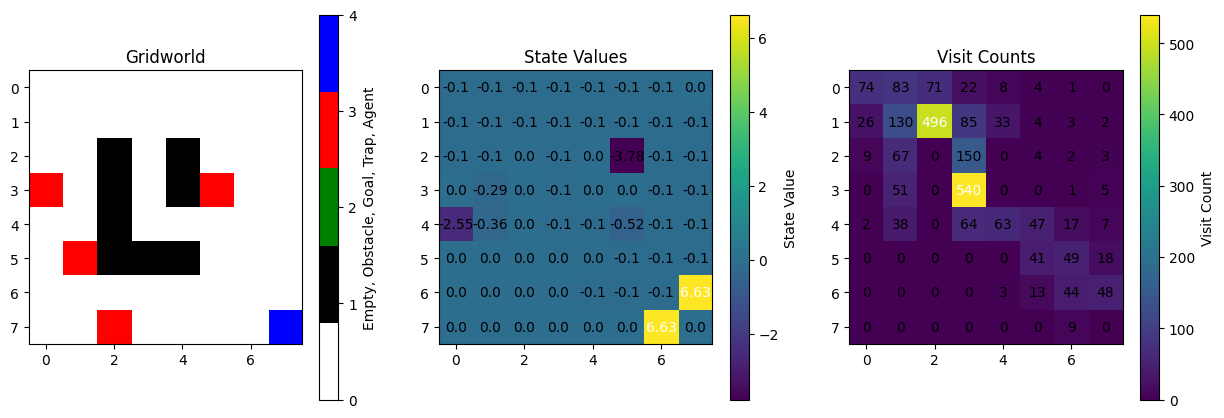

Running 200 episodes...


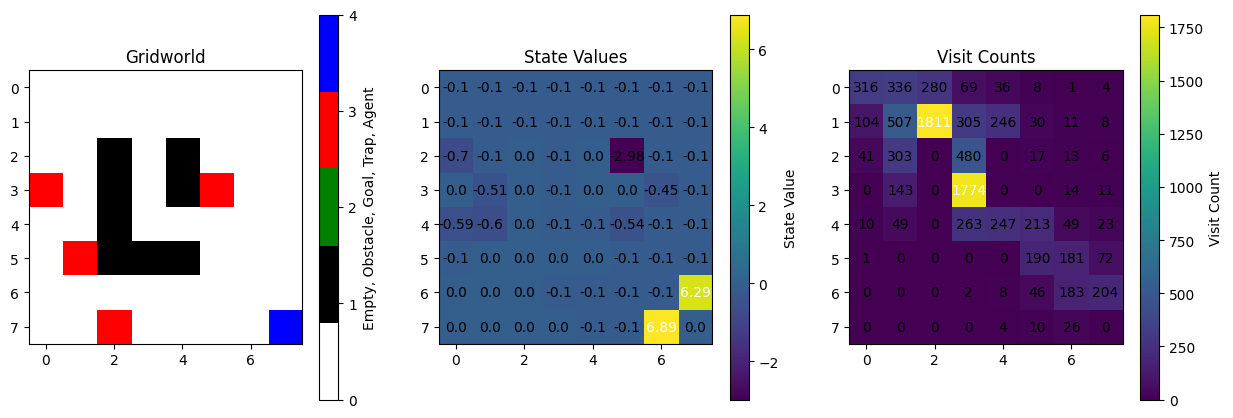

Running 500 episodes...


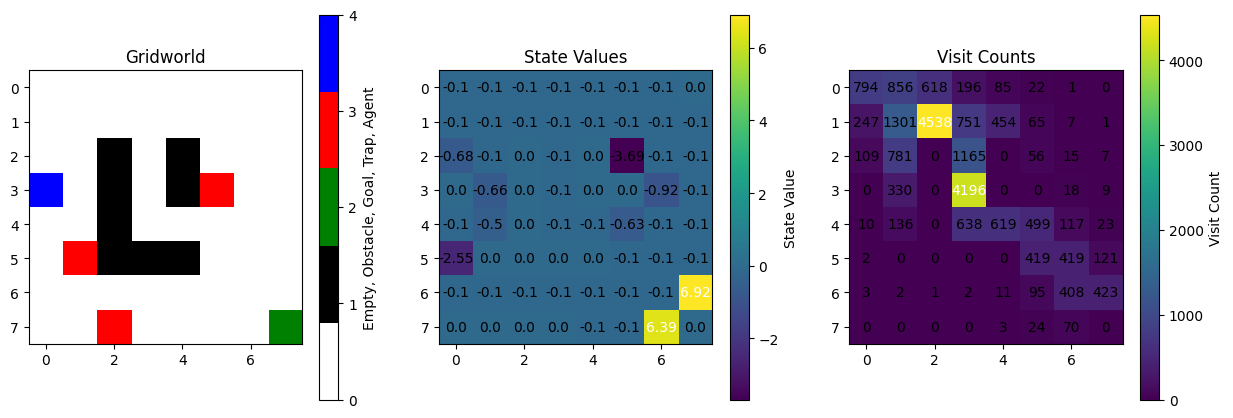

Running 1000 episodes...


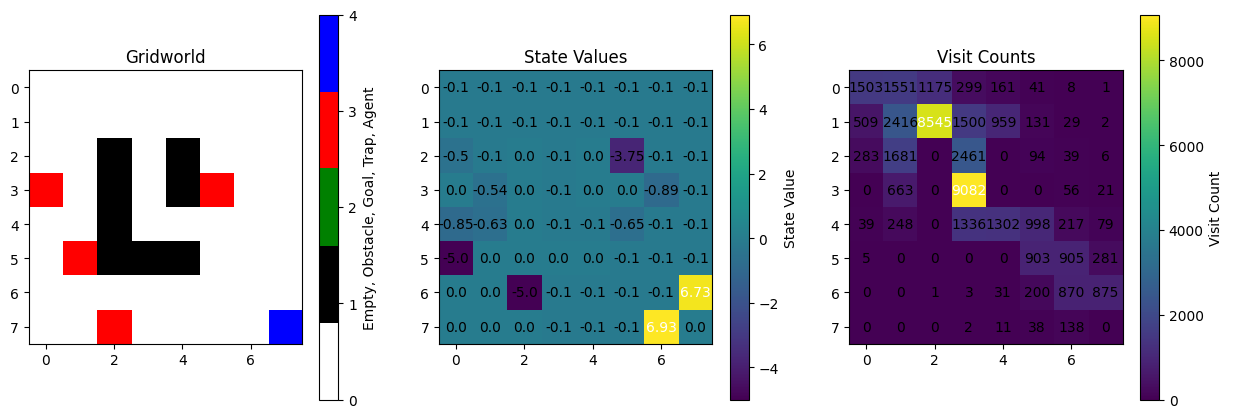

Running 10000 episodes...


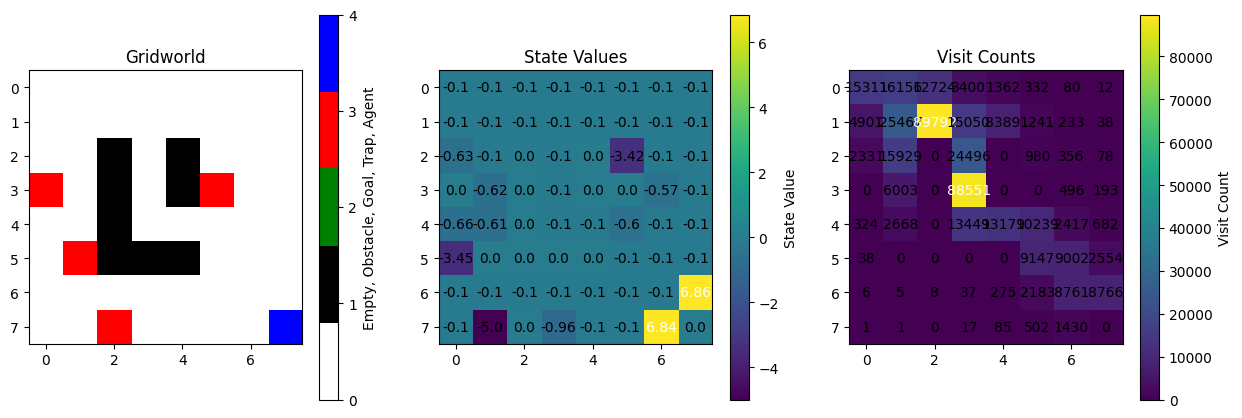

In [135]:
env = GridWorld(grid_size=8, 
                start_state=(0,0), 
                goal_states=[(7,7)], 
                obstacles=[(2,2),(2,4),(3,2),(3,4),(4,2),(5,2),(5,3),(5,4)], 
                traps=[(3,0),(3,5),(5,1),(7,2)])
agent = Agent(env)

for episodes in [50, 200, 500, 1000, 10000]:
    print(f'Running {episodes} episodes...')
    values, counts = agent.evaluate_policy(episodes)